In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.feature_extraction.text import HashingVectorizer
import numpy as np
import pandas as pd
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pickle

In [ ]:
chunks = []
for chunk in pd.read_csv('combined_dataset.csv', chunksize=10000):
    chunks.append(chunk)
df = pd.concat(chunks, axis=0)

In [ ]:
# Try reading with error_bad_lines=False to skip problematic rows
#df = pd.read_csv('combined_dataset.csv', error_bad_lines=False)

In [ ]:
models = {
    "SVM": SVC(kernel='linear', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

In [ ]:
df.drop('Unnamed: 0',axis=1, inplace=True)

In [ ]:
df.describe()

,label
count,151254.000000
mean,0.530075
std,0.499096
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151254 entries, 0 to 151253
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   payload  151253 non-null  object
 1   label    151254 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150568 entries, 0 to 151253
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   payload  150568 non-null  object
 1   label    150568 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


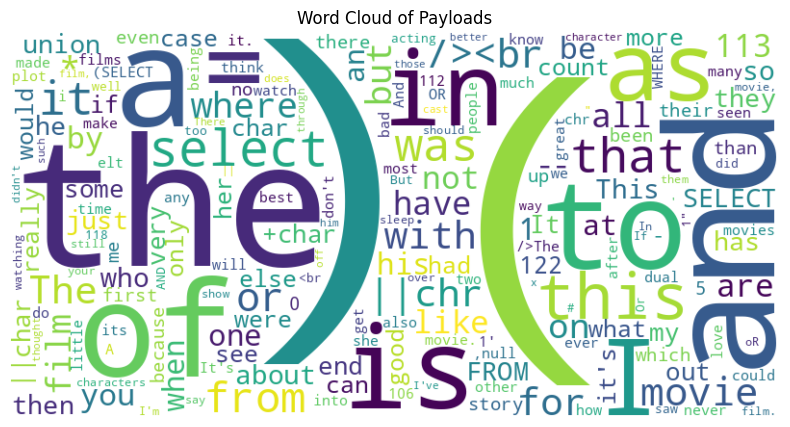

In [ ]:
all_text = " ".join(df["payload"])
word_counts = Counter(all_text.split())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Payloads")
plt.show()

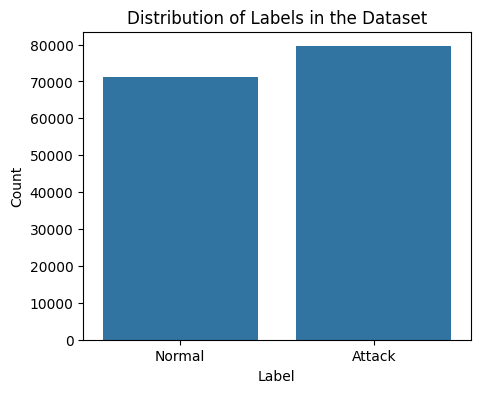

In [ ]:
label_counts = df["label"].value_counts()

plt.figure(figsize=(5, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels in the Dataset")
plt.xticks([0, 1], ["Normal", "Attack"])
plt.show()

In [ ]:
X = df['payload']
y = df['label']

In [ ]:
def preprocess_text(text):

    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [ ]:
X_processed = [preprocess_text(payload) for payload in X]
vectorizer = HashingVectorizer(
    analyzer='char',
    ngram_range=(3, 5),
    n_features=2**20,
    dtype=np.float32
)
X_features = vectorizer.transform(X_processed)
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.3, random_state=42)

In [ ]:
#random_forest_model = RandomForestClassifier(
 #   n_estimators=100,
  #  n_jobs=-1,
   # random_state=42
#)
#random_forest_model.fit(X_train, y_train)

In [ ]:
import pickle
import time
import numpy as np
from joblib import Parallel, delayed
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
'''
# 1. Optimized model configurations
models = {
    "SVM": LinearSVC(dual=False, max_iter=50, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5, algorithm='brute', n_jobs=-1),
    "RandomForest": RandomForestClassifier(
        n_estimators=80, max_depth=12,
        min_samples_split=10, n_jobs=-1, random_state=42
    ),
    "LogReg": LogisticRegression(
        solver='saga', max_iter=200,
        n_jobs=-1, random_state=42
    )
}
'''
import os

# 1. Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)  # <-- Fixes directory issue

def train_and_evaluate(name, model):
    start_time = time.time()

    # Train model
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)

    # Save model (corrected file extension)
    filename = f"models/{name.lower()}_model.pkl"  # .pkl not .pk1
    with open(filename, "wb") as f:
        pickle.dump(model, f)



# 2. Preprocess data once (outside loop)
X_train = X_train.astype('float32')  # Reduce memory usage by 50%
X_test = X_test.astype('float32')

# 3. Parallel training and evaluation
def train_and_evaluate(name, model):
    start_time = time.time()

    # Train model
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)

    # Save model
    with open(f"models/{name.lower()}_model.pkl", "wb") as f:
        pickle.dump(model, f)

    return {
        "name": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "time": time.time() - start_time
    }

# 4. Run models in parallel
# 1. Fix syntax and enable full parallel processing
results = Parallel(n_jobs=-1)(  # Use all CPU cores (-1)
    delayed(train_and_evaluate)(name, model)
    for name, model in models.items()
)
results = Parallel(n_jobs=-1)(
    delayed(train_and_evaluate)(name, model)
    for name, model in models.items()
)

# 5. Save vectorizer once (outside loop)
with open("models/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# 6. Print results after completion
print("\nFinal Performance Summary:")
for result in results:
    print(f"\n{result['name']}:")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"Training Time: {result['time']:.1f}s")



KeyboardInterrupt: 

In [ ]:
import pickle
import os
import time
import numpy as np
from joblib import Parallel, delayed
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 1. Create models directory
os.makedirs('models', exist_ok=True)

# 2. Hyper-optimized model configurations
models = {
    "SVM": LinearSVC(
        dual=False,
        max_iter=100,  # Reduced from 50
        tol=1e-3,      # Looser tolerance
        random_state=42
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=5,
        algorithm='brute',
        leaf_size=30,  # Optimized tree leaf size
        n_jobs=-1
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=30,    # Reduced from 80
        max_depth=10,       # Reduced from 12
        min_samples_split=20,  # Increased from 10
        n_jobs=-1,
        random_state=42
    ),
    "LogReg": LogisticRegression(
        solver='sag',       # Faster than saga for many samples
        max_iter=100,       # Reduced from 200
        tol=1e-3,           # Looser tolerance
        n_jobs=-1,
        random_state=42
    )
}

# 3. Data optimization
X_train = X_train.astype('float32').tocsr()  # CSR format for sparse data
X_test = X_test.astype('float32').tocsr()

# 4. Single definition of training function
def train_and_evaluate(name, model):
    start_time = time.time()

    # Train model
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)

    # Save model
    with open(f"models/{name.lower()}_model.pkl", "wb") as f:
        pickle.dump(model, f)

    return {
        "name": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "time": time.time() - start_time
    }

# 5. Parallel execution with memory mapping
results = Parallel(n_jobs=-1, prefer='threads')(
    delayed(train_and_evaluate)(name, model)
    for name, model in models.items()
)

# 6. Save vectorizer once
with open("models/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# 7. Quick results summary
print("\nPerformance Summary (Time-Optimized):")
for result in results:
    print(f"{result['name']}: {result['time']:.1f}s | Acc: {result['accuracy']:.3f}")

KeyboardInterrupt: 

In [ ]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Store metrics
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred)
    }

    # Save the model
    pickle.dump(model, open(f"models/{name.lower().replace(' ', '_')}_model.pkl", "wb"))

# Save vectorizer
pickle.dump(vectorizer, open("models/tfidf_vectorizer.pkl", "wb"))

# Print results
print("Model Performance:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    print(f"Accuracy: {metrics['Accuracy']:.2f}")
    print(f"Precision: {metrics['Precision']:.2f}")
    print(f"Recall: {metrics['Recall']:.2f}")

In [ ]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

In [ ]:
models = {
    "SVM": SVC(kernel='linear', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_model = XGBClassifier(tree_method="hist", n_jobs=-1)
xgb_model.fit(X_train, y_train)